In [1]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/5b/0b/e45d26ccd28568013523e04f325432ea88a442b4e3020b757cf4361f0120/transformers-4.30.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 21.0 MB/s eta 0:00:00
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/00/45/ec3407adf6f6b5bf867a4462b2b0af27597a26bd3cd6e2534cb6ab029938/filelock-3.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/9a/05/18911646

In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Initialize the RoBERTa model
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the model
try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded successfully.


In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from tqdm import tqdm
from scipy.special import softmax

# Load your labeled dataset (replace with your actual dataset path)
labeled_df = pd.read_csv("/jupyter/work/sentiment-tweets.csv")

# Example dataset structure:
# labeled_df = pd.DataFrame({
#     'Tweet': ["I love this!", "This is terrible.", "It's okay."],
#     'True_Sentiment': ["positive", "negative", "neutral"]
# })



ModuleNotFoundError: No module named 'transformers'

In [6]:
labeled_df[['Text','sentiment']]

Text sentiment
0      @Logitech @apple @Google @Microsoft @Dell @Len...   neutral
1      @MK_habit_addict @official_stier @MortalKombat...   neutral
2      As @CRN celebrates its 40th anniversary, Bob F...  positive
3      @dell your customer service is horrible especi...  negative
4      @zacokalo @Dell @DellCares @Dell give the man ...   neutral
...                                                  ...       ...
24965  @ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...  negative
24966  @kite_real @GamersNexus @Dell I didn't really ...  positive
24967  Hey @JoshTheFixer here it is....27 4K UHD USB-...   neutral
24968  @bravadogaming @thewolfpena @Alienware @intel ...   neutral
24969  @rabia_ejaz @Dell Stopped buying windows lapto...  positive

[24970 rows x 2 columns]

Evaluating: 100%|██████████| 781/781 [04:31<00:00,  2.88batch/s]


Accuracy: 0.9327

Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.95      0.95     10556
     neutral       0.87      0.90      0.89      7048
    positive       0.96      0.94      0.95      7366

    accuracy                           0.93     24970
   macro avg       0.93      0.93      0.93     24970
weighted avg       0.93      0.93      0.93     24970



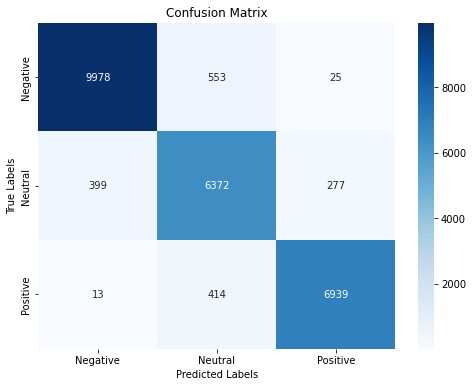

In [7]:
# Preprocess function to clean tweets (e.g., replace URLs, mentions)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Preprocess and tokenize the labeled tweets
labeled_df['preprocessed_tweet'] = labeled_df['Text'].apply(preprocess)
encoded_comments = tokenizer(list(labeled_df['preprocessed_tweet']), padding=True, truncation=True, return_tensors='pt')

# Create a DataLoader for batching
dataset = TensorDataset(encoded_comments['input_ids'], encoded_comments['attention_mask'])
dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=32)

# Predict sentiment using the model
model.eval()
predicted_labels = []
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        input_ids, attention_mask = batch[0].to(device), batch[1].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        scores = softmax(logits.cpu().numpy(), axis=1)
        predicted_class = scores.argmax(axis=1)
        predicted_labels.extend(predicted_class)

# Convert numeric predictions to class labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_map[label] for label in predicted_labels]

# Add predictions to the DataFrame
labeled_df['Predicted_Sentiment'] = predicted_labels

# Evaluate the model using sklearn metrics
true_labels = labeled_df['sentiment'].tolist()
predicted_labels = labeled_df['Predicted_Sentiment'].tolist()

# Calculate and display evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["negative", "neutral", "positive"]))

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [3]:
# Load the comments and stock prices data
try:
    tweets_df = pd.read_csv('/jupyter/work/stock_tweets.csv')
    stock_prices_df = pd.read_csv('/jupyter/work/stock_yfinance_data.csv')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    


Data loaded successfully.


In [7]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
    


In [45]:
# Preprocess and predict sentiment for each comment
def get_sentiment(text):
    processed_text = preprocess(text)
    encoded_input = tokenizer(processed_text, return_tensors='pt')
    with torch.no_grad():  # This line ensures gradients are not computed
        output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return score

In [7]:
tweets_df

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
...                          ...   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
...                                                  ...        ...   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name  
0      Tesla, Inc.  
1      Tesla, Inc.  
2      Tesla, Inc.  
3      Tesla, Inc.  
4      Tesla, Inc.  
...            ...  
80788   XPeng Inc.  
80789   XPeng Inc.  
80790   XPeng Inc.  
80791   XPeng Inc.  
80792   XPeng Inc.  

[80793 rows x 4 columns]

In [8]:
stock_prices_df

Date        Open        High         Low       Close   Adj Close  \
0     2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1     2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2     2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3     2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4     2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...          ...         ...         ...         ...         ...         ...   
6295  2022-09-23   13.090000   13.892000   12.860000   13.710000   13.710000   
6296  2022-09-26   14.280000   14.830000   14.070000   14.370000   14.370000   
6297  2022-09-27   14.580000   14.800000   13.580000   13.710000   13.710000   
6298  2022-09-28   13.050000   13.421000   12.690000   13.330000   13.330000   
6299  2022-09-29   12.550000   12.850000   11.850000   12.110000   12.110000   

        Volume Stock Name  
0     53868000       TSLA  
1     51094200       TSLA  
2     91449900       TSLA  
3     55297800       TSLA  
4     43898400       TSLA  
...        ...        ...  
6295  28279600       XPEV  
6296  27891300       XPEV  
6297  21160800       XPEV  
6298  31799400       XPEV  
6299  33044800       XPEV  

[6300 rows x 8 columns]

In [6]:
#tweets_df = tweets_df.drop('sentiment_scores',axis=1)
tweets_df.head(100)

Date  \
0   2022-09-29 23:41:16+00:00   
1   2022-09-29 23:24:43+00:00   
2   2022-09-29 23:18:08+00:00   
3   2022-09-29 22:40:07+00:00   
4   2022-09-29 22:27:05+00:00   
..                        ...   
95  2022-09-29 05:51:42+00:00   
96  2022-09-29 05:38:00+00:00   
97  2022-09-29 05:19:26+00:00   
98  2022-09-29 04:46:00+00:00   
99  2022-09-29 04:33:59+00:00   

                                                Tweet Stock Name Company Name  
0   Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1   Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2   3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3   @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4   @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  
..                                                ...        ...          ...  
95  Next year the city streets are going to be ver...       TSLA  Tesla, Inc.  
96  Tesla Full Self-Driving Beta is trained on dat...       TSLA  Tesla, Inc.  
97  “The code you will write will at term run in m...       TSLA  Tesla, Inc.  
98  FSD SAVES LIVES. $TSLA \n\nhttps://t.co/4p8wnl...       TSLA  Tesla, Inc.  
99  "If you say, 'OK, who is Tesla hurting the mos...       TSLA  Tesla, Inc.  

[100 rows x 4 columns]

In [10]:
import os

print("Current working directory:", os.getcwd())

Current working directory: /jupyter/work


In [3]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Preprocessing function
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Check if CUDA is available and set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move the model to the device
model.to(device)
batch_size = 128

# Preprocess and tokenize all comments
tweets_df['preprocessed_tweet'] = tweets_df['Tweet'].apply(preprocess)
encoded_comments = tokenizer(list(tweets_df['preprocessed_tweet']), padding=True, truncation=True, return_tensors='pt')

# Create a TensorDataset and DataLoader
dataset = TensorDataset(encoded_comments['input_ids'], encoded_comments['attention_mask'])
dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

# Now, iterate over batches and make predictions using the GPU
model.eval()  # Set the model to evaluation mode
negative_scores = []
neutral_scores = []
positive_scores = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        input_ids, attention_mask = batch

        # Move the batch to the device (e.g., GPU or CPU)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Compute the logits
        outputs = model(input_ids, attention_mask=attention_mask)
        scores = outputs.logits.detach().cpu().numpy()  # Move the logits back to CPU
        scores = softmax(scores, axis=1)

        # Extend the lists with the individual scores
        negative_scores.extend(scores[:, 0])
        neutral_scores.extend(scores[:, 1])
        positive_scores.extend(scores[:, 2])

# Add the individual sentiment scores to the DataFrame
tweets_df['positive_sentiment'] = positive_scores
tweets_df['neutral_sentiment'] = neutral_scores
tweets_df['negative_sentiment'] = negative_scores


Using device: cuda:0


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Evaluating: 100%|██████████| 632/632 [21:56<00:00,  2.08s/batch]


In [12]:
# Saving the tweets dataframe with sentiment scores to a CSV file
tweets_df.to_csv('/jupyter/work/sentiment_scores.csv', index=False)

In [4]:
tweets_df

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
...                          ...   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
...                                                  ...        ...   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name                                 preprocessed_tweet  \
0      Tesla, Inc.  Mainstream media has done an amazing job at br...   
1      Tesla, Inc.  Tesla delivery estimates are at around 364k fr...   
2      Tesla, Inc.  3/ Even if I include 63.0M unvested RSUs as of...   
3      Tesla, Inc.  @user @user @user Hahaha why are you still try...   
4      Tesla, Inc.  @user @user Stop trying to kill kids, you sad ...   
...            ...                                                ...   
80788   XPeng Inc.  Some of the fastest growing tech stocks on the...   
80789   XPeng Inc.  With earnings on the horizon, here is a quick ...   
80790   XPeng Inc.  Our record delivery results are a testimony of...   
80791   XPeng Inc.  We delivered 10,412 Smart EVs in Sep 2021, rea...   
80792   XPeng Inc.  Why can XPeng P5 deliver outstanding performan...   

       positive_sentiment  neutral_sentiment  negative_sentiment  
0                0.057338           0.233858            0.708804  
1                0.314792           0.675301            0.009908  
2                0.078452           0.890413            0.031134  
3                0.012000           0.072386            0.915614  
4                0.005153           0.045158            0.949689  
...                   ...                ...                 ...  
80788            0.948147           0.048571            0.003282  
80789            0.422630           0.569156            0.008215  
80790            0.913733           0.083170            0.003098  
80791            0.943326           0.054282            0.002393  
80792            0.870371           0.125049            0.004580  

[80793 rows x 8 columns]

Matplotlib is building the font cache; this may take a moment.


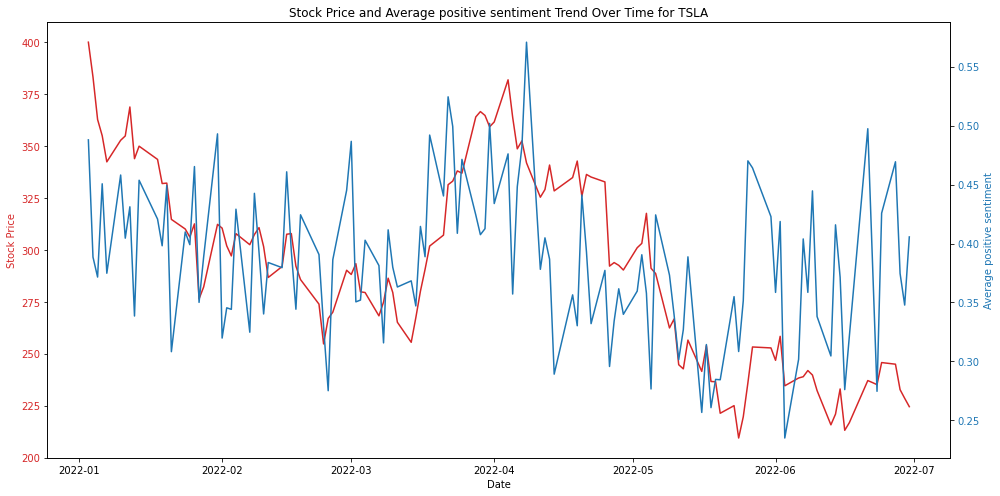

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

sentiment_type = 'positive_sentiment'


# Assuming sentiment_scores is already a list of floats and split into three columns
tweets_df = pd.read_csv('/jupyter/work/sentiment_scores.csv')
stock_prices_df = pd.read_csv('./stock_yfinance_data.csv')

# Convert the 'Date' columns to datetime and normalize to just the date
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date']).dt.date

# Merge the sentiment data with the stock prices data on the date and stock name
merged_df = pd.merge(stock_prices_df, tweets_df, left_on=['Date', 'Stock Name'], right_on=['Date', 'Stock Name'])

# Group by Date and Stock Name, and then calculate the mean sentiment
average_sentiment_per_day = merged_df.groupby(['Date', 'Stock Name'])[sentiment_type].mean().reset_index()

# Merge the average sentiment back with the stock prices
merged_with_average_sentiment = pd.merge(stock_prices_df, average_sentiment_per_day, on=['Date', 'Stock Name'])

# Filter for a specific stock
specific_stock_df = merged_with_average_sentiment[merged_with_average_sentiment['Stock Name'] == 'TSLA']

# Set the date as the index for the specific stock
specific_stock_df.set_index('Date', inplace=True)

start_date = '2022-01-01'
end_date = '2022-06-30'

# Convert strings to datetime
start_date = pd.to_datetime(start_date).date()
end_date = pd.to_datetime(end_date).date()

# Filter the DataFrame for the date range
specific_stock_df = specific_stock_df[(specific_stock_df.index >= start_date) & (specific_stock_df.index <= end_date)]


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the stock prices
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color=color)
ax1.plot(specific_stock_df.index, specific_stock_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the average positive sentiment score
color = 'tab:blue'
ax2.set_ylabel(f'Average {sentiment_type.replace("_"," ")}', color=color)
ax2.plot(specific_stock_df.index, specific_stock_df[sentiment_type], color=color, marker=' ')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title(f'Stock Price and Average {sentiment_type.replace("_"," ")} Trend Over Time for TSLA')
fig.tight_layout()

# Show the plot
plt.show()

Matplotlib is building the font cache; this may take a moment.


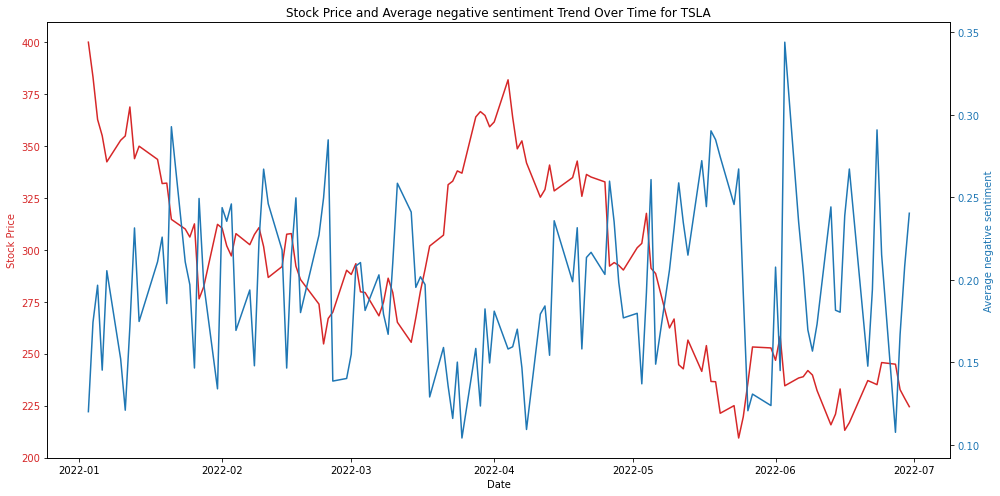

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

sentiment_type = 'negative_sentiment'


# Assuming sentiment_scores is already a list of floats and split into three columns
tweets_df = pd.read_csv('/jupyter/work/sentiment_scores.csv')
stock_prices_df = pd.read_csv('./stock_yfinance_data.csv')

# Convert the 'Date' columns to datetime and normalize to just the date
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date']).dt.date

# Merge the sentiment data with the stock prices data on the date and stock name
merged_df = pd.merge(stock_prices_df, tweets_df, left_on=['Date', 'Stock Name'], right_on=['Date', 'Stock Name'])

# Group by Date and Stock Name, and then calculate the mean sentiment
average_sentiment_per_day = merged_df.groupby(['Date', 'Stock Name'])[sentiment_type].mean().reset_index()

# Merge the average sentiment back with the stock prices
merged_with_average_sentiment = pd.merge(stock_prices_df, average_sentiment_per_day, on=['Date', 'Stock Name'])

# Filter for a specific stock
specific_stock_df = merged_with_average_sentiment[merged_with_average_sentiment['Stock Name'] == 'TSLA']

# Set the date as the index for the specific stock
specific_stock_df.set_index('Date', inplace=True)

start_date = '2022-01-01'
end_date = '2022-06-30'

# Convert strings to datetime
start_date = pd.to_datetime(start_date).date()
end_date = pd.to_datetime(end_date).date()

# Filter the DataFrame for the date range
specific_stock_df = specific_stock_df[(specific_stock_df.index >= start_date) & (specific_stock_df.index <= end_date)]


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the stock prices
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color=color)
ax1.plot(specific_stock_df.index, specific_stock_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the average negative sentiment score
color = 'tab:blue'
ax2.set_ylabel(f'Average {sentiment_type.replace("_"," ")}', color=color)
ax2.plot(specific_stock_df.index, specific_stock_df[sentiment_type], color=color, marker=' ')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title(f'Stock Price and Average {sentiment_type.replace("_"," ")} Trend Over Time for TSLA')
fig.tight_layout()

# Show the plot
plt.show()

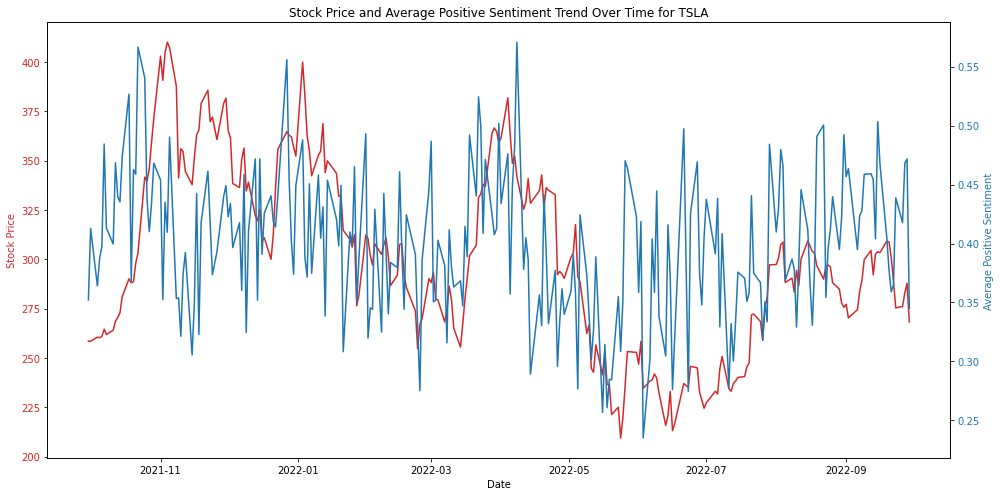

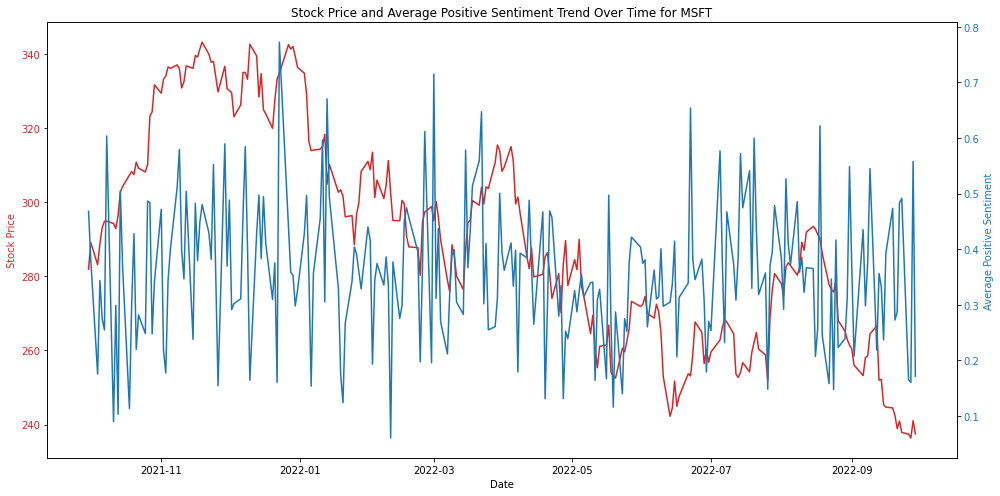

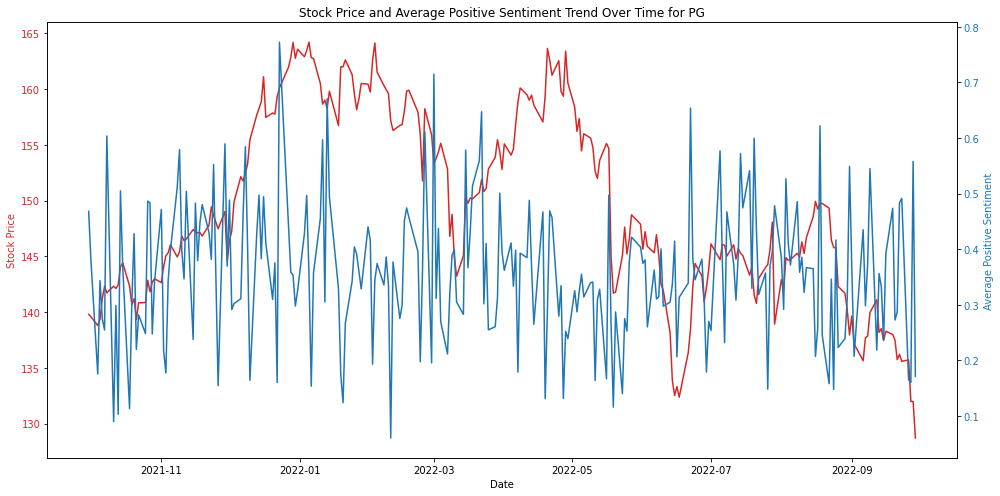

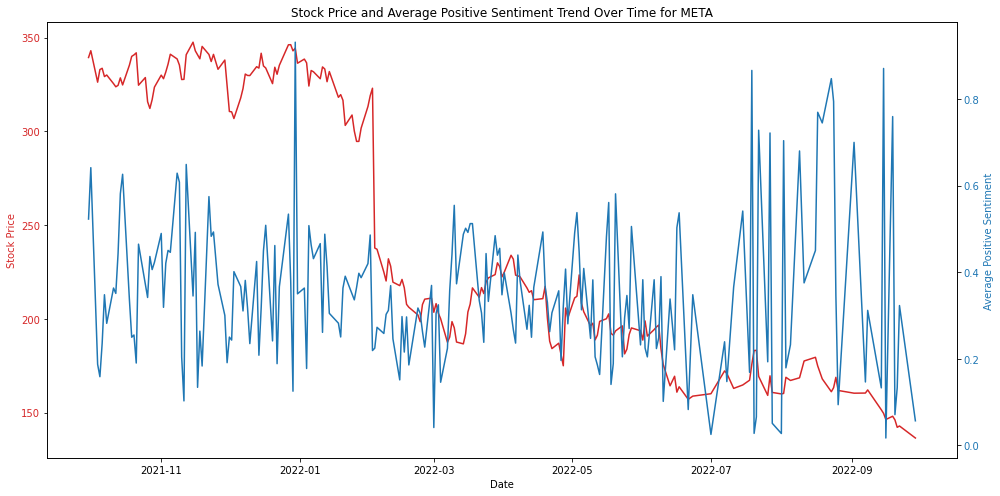

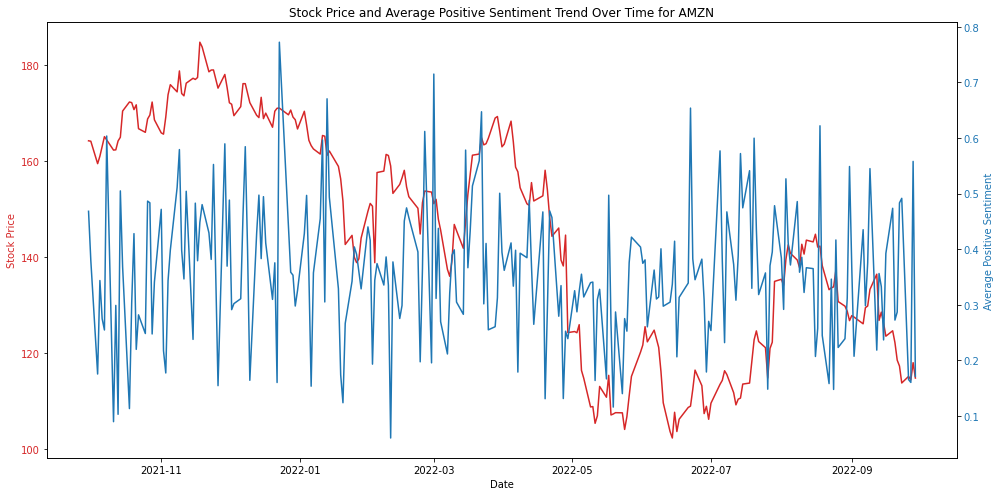

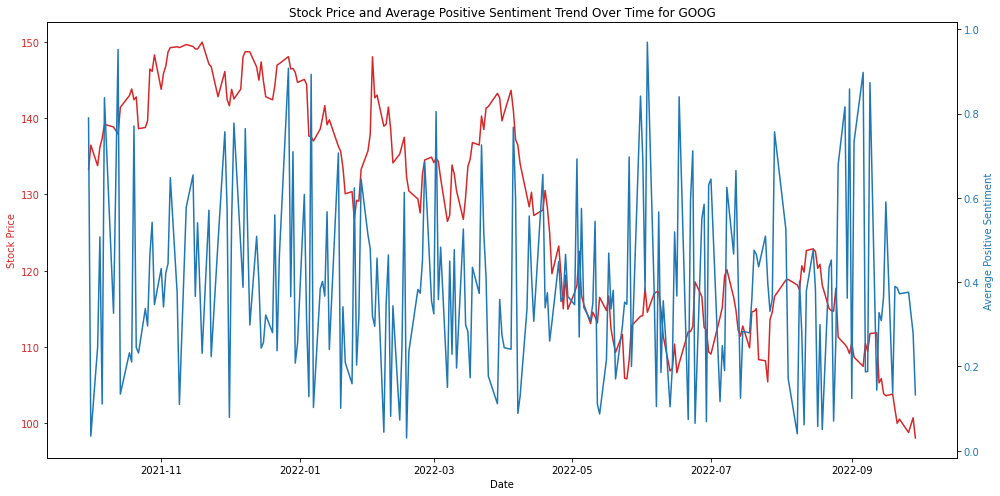

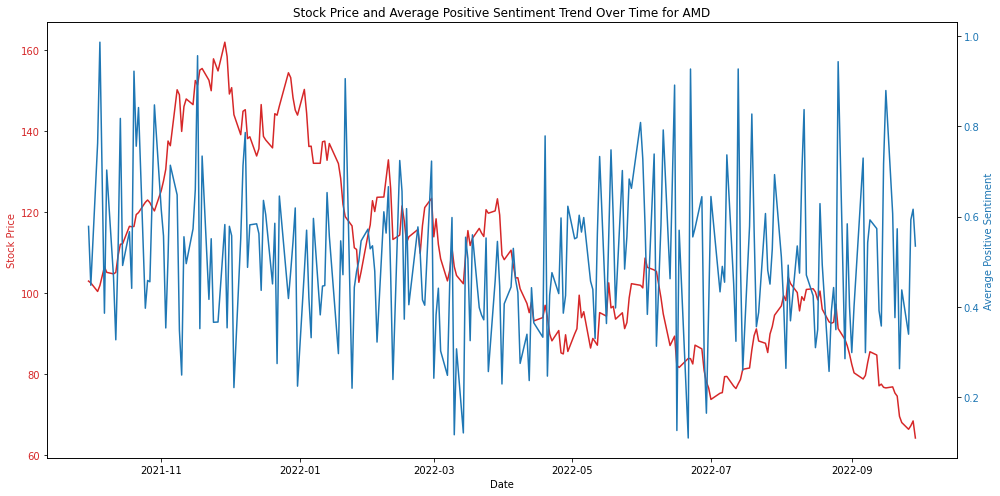

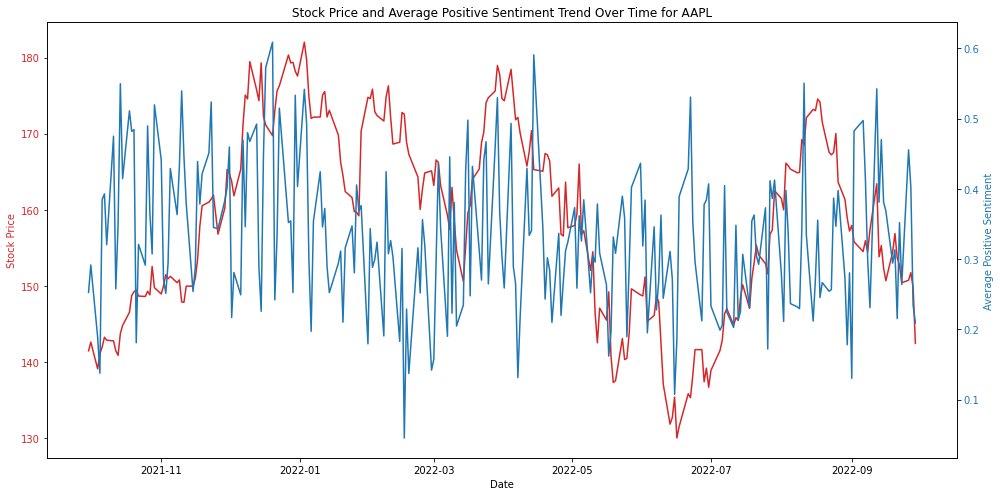

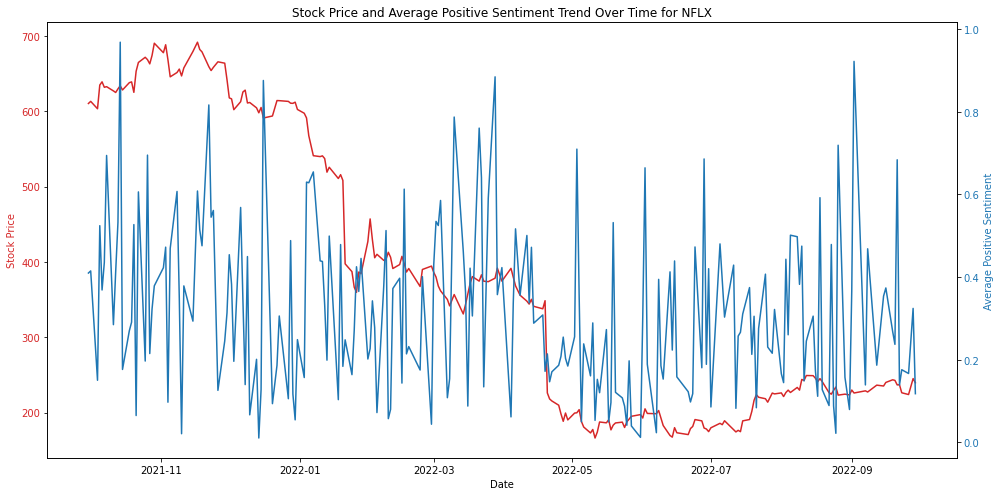

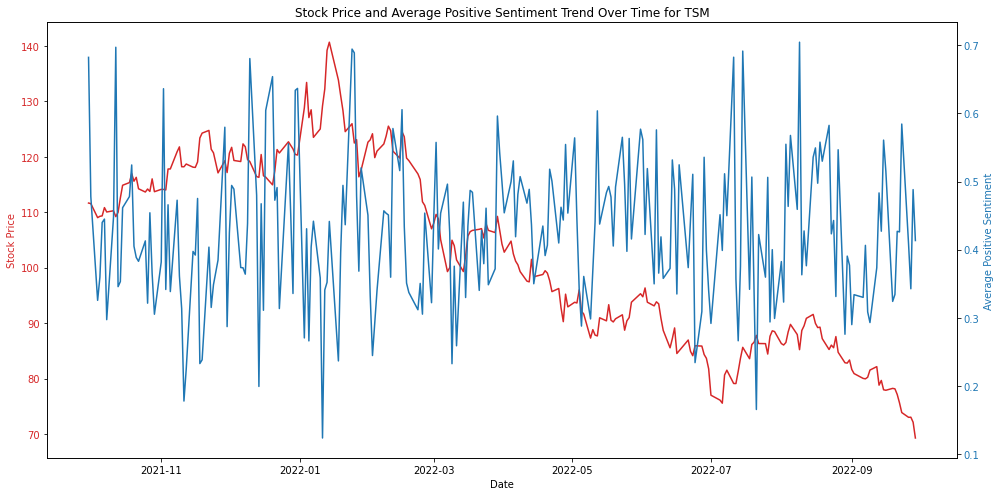

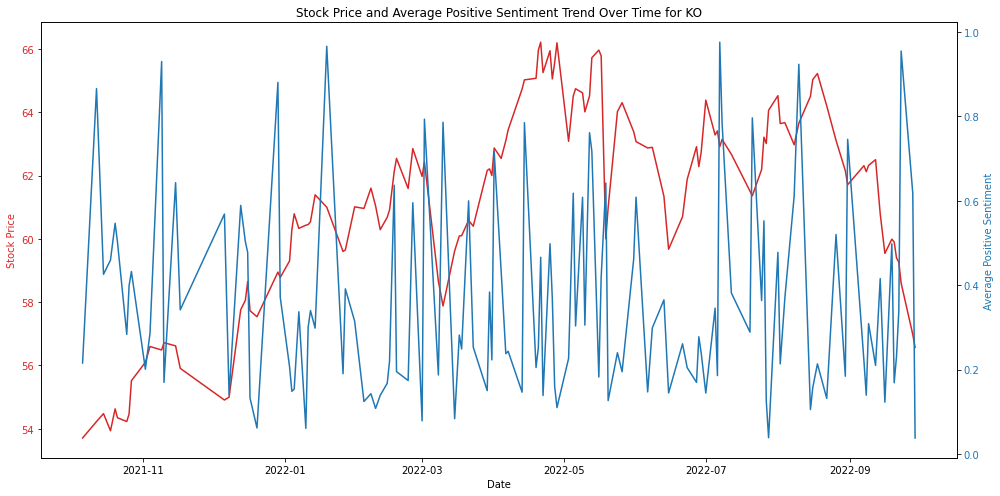

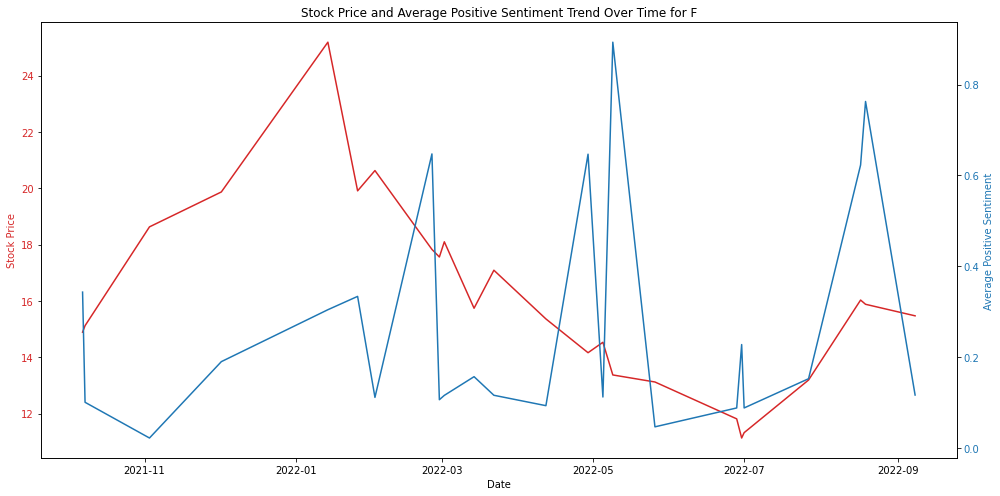

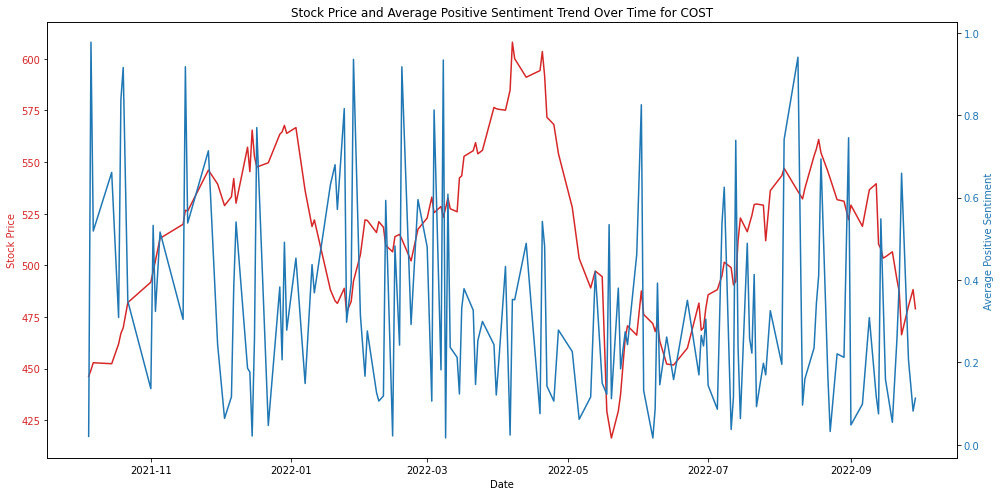

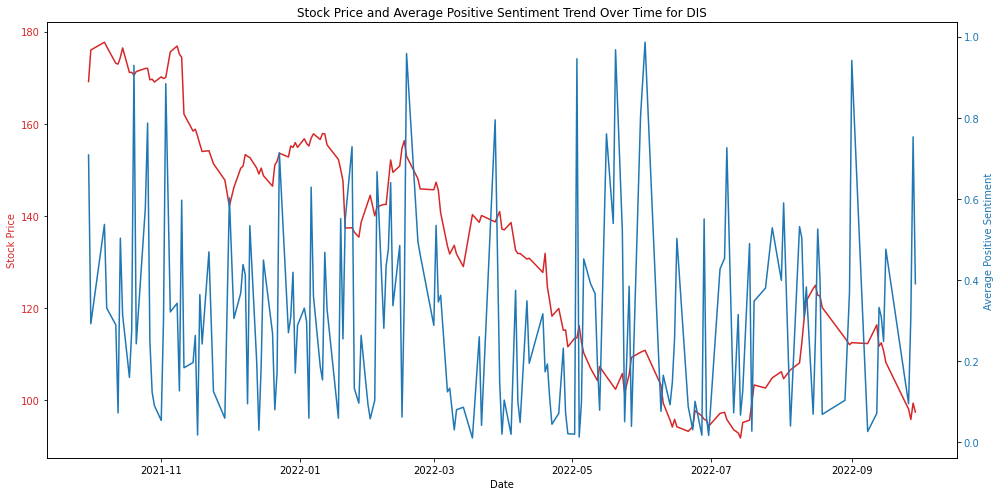

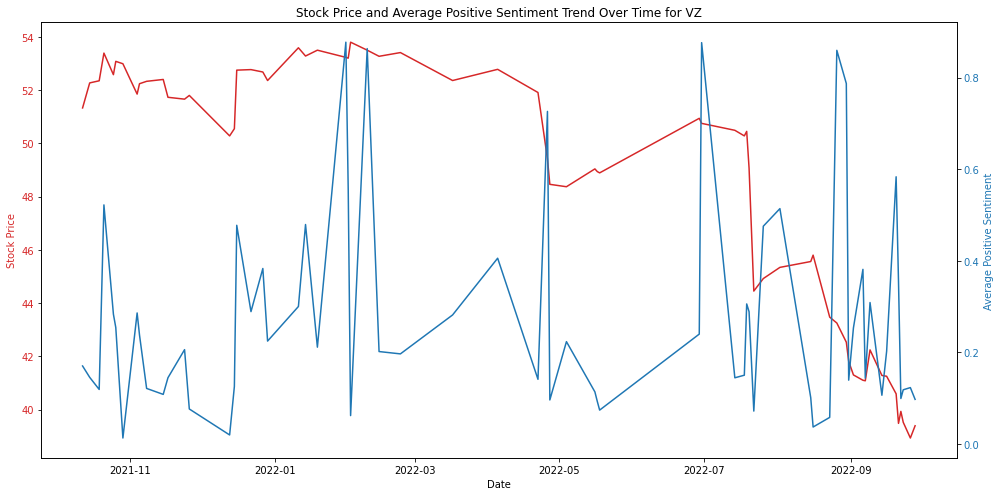

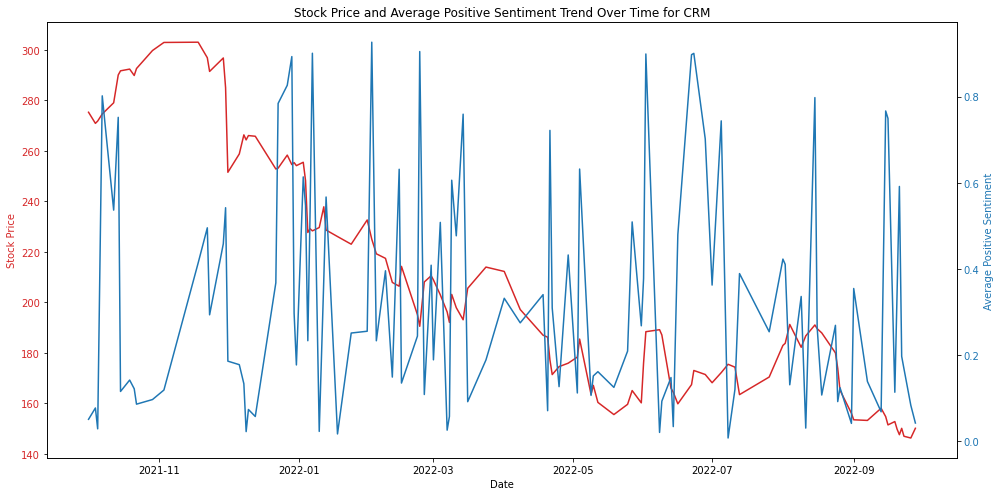

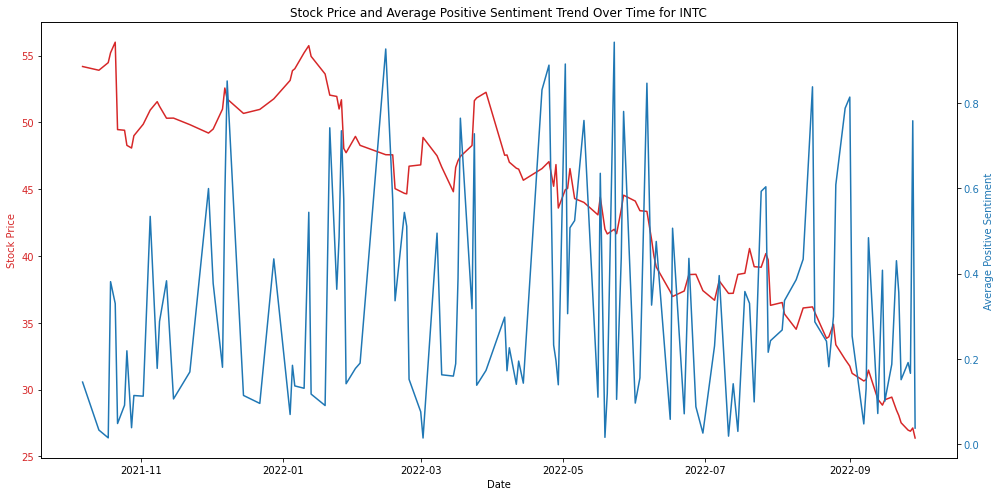

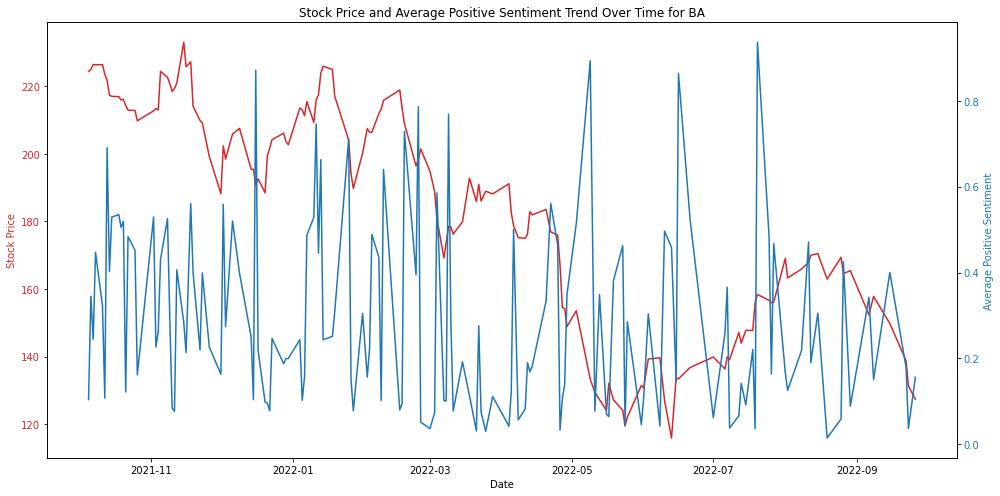

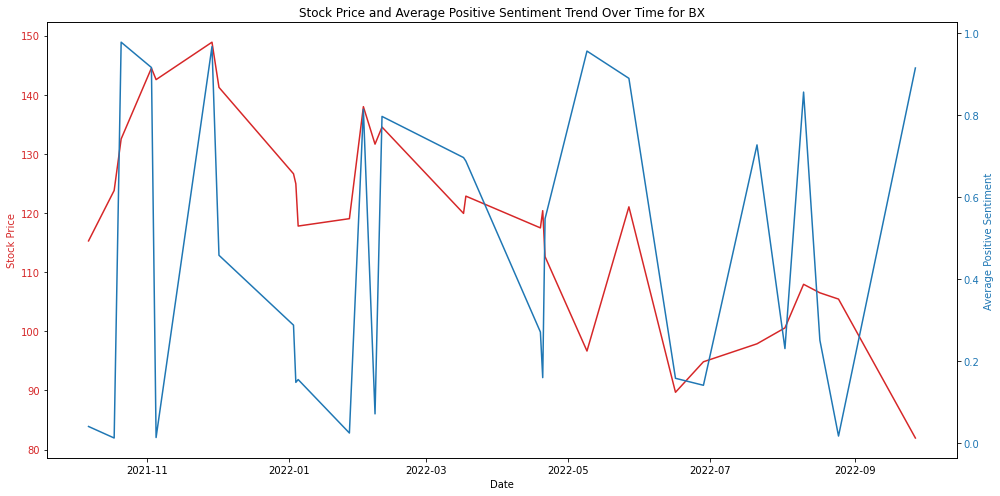

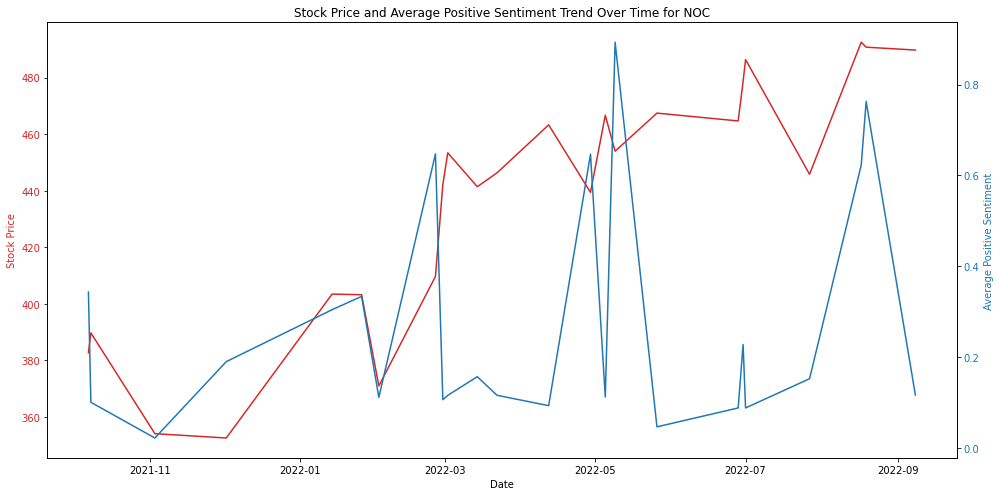

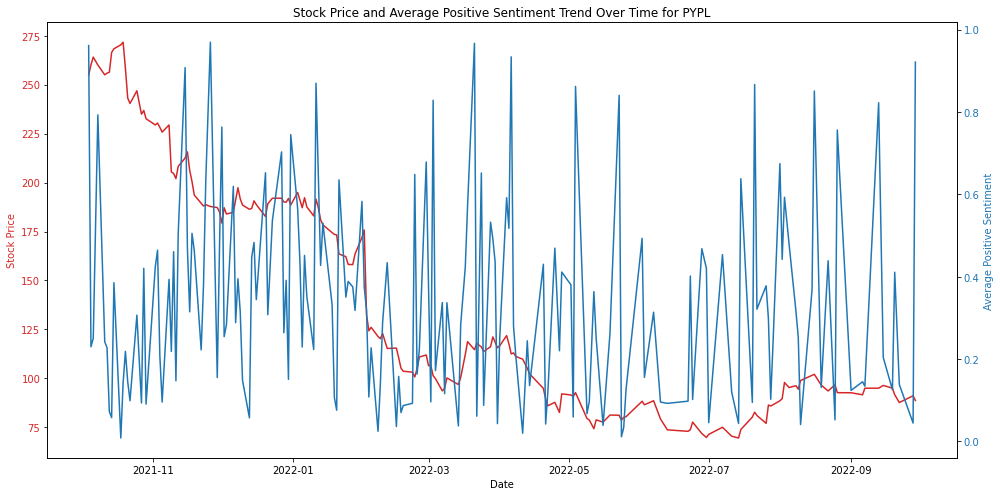

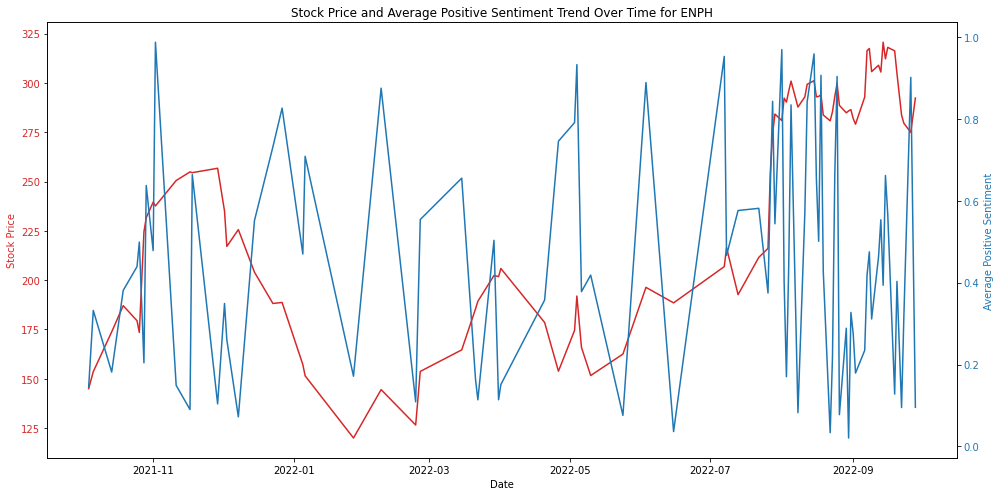

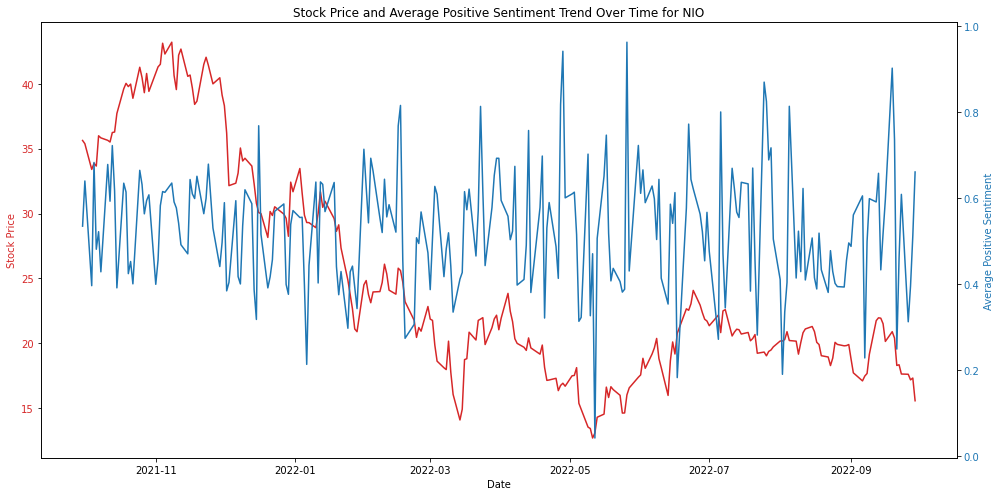

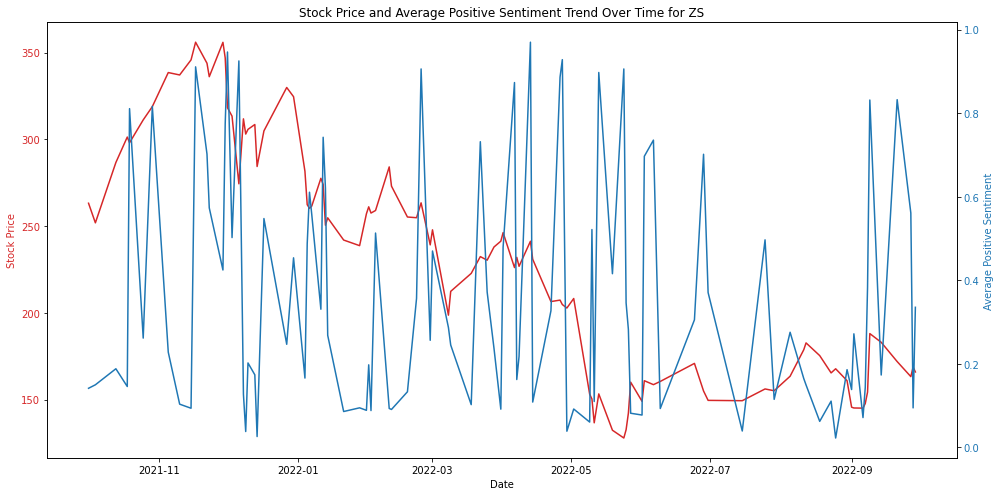

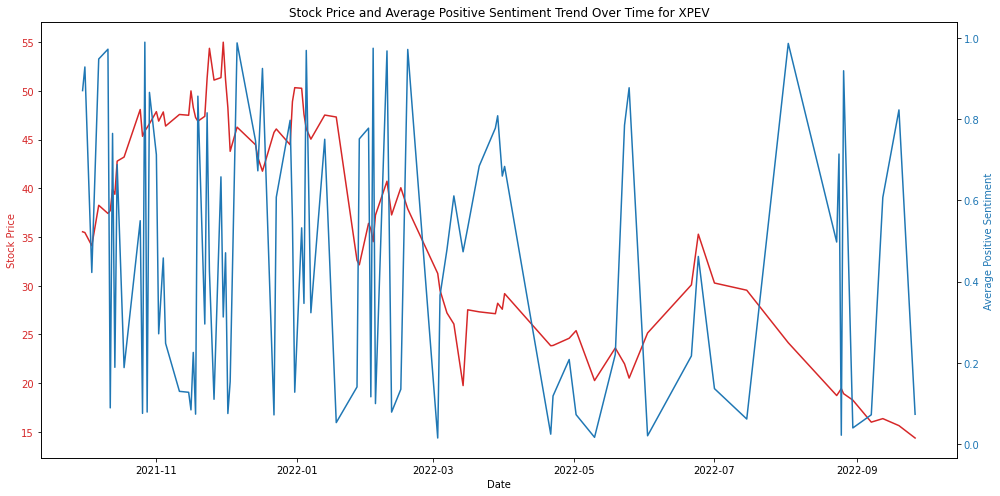

In [13]:

# import matplotlib.pyplot as plt

# Get unique stock names
unique_stocks = merged_with_average_sentiment['Stock Name'].unique()

# Loop through each stock name and create a plot
for stock_name in unique_stocks:
    # Filter for a specific stock
    specific_stock_df = merged_with_average_sentiment[merged_with_average_sentiment['Stock Name'] == stock_name]

    # Set the date as the index for the specific stock
    specific_stock_df.set_index('Date', inplace=True)

    # Start plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot the stock prices
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price', color=color)
    ax1.plot(specific_stock_df.index, specific_stock_df['Close'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the average positive sentiment score
    color = 'tab:blue'
    ax2.set_ylabel('Average Positive Sentiment', color=color)
    ax2.plot(specific_stock_df.index, specific_stock_df['positive_sentiment'], color=color, marker=' ')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title(f'Stock Price and Average Positive Sentiment Trend Over Time for {stock_name}')
    fig.tight_layout()

    # Show the plot
    plt.show()

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

stock_name = 'TSLA'
stock_df = stock_prices_df[stock_prices_df['Stock Name'] == stock_name].copy()

stock_df['Date'] = pd.to_datetime(stock_df['Date'])
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])

# Group tweets_df by 'Date' and calculate the mean sentiment scores
tweets_df = tweets_df.groupby('Date').mean().reset_index()

# Merge the stock prices and sentiment scores DataFrames on the 'Date' column
merged_df = pd.merge(stock_df, tweets_df, on='Date', how='inner')  # Use 'inner' to only keep rows that have a match in both DataFrames
merged_df.set_index('Date', inplace=True)


In [15]:
merged_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...                ...         ...         ...         ...         ...   
2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

              Volume Stock Name  negative_sentiment  neutral_sentiment  \
Date                                                                     
2021-09-30  53868000       TSLA            0.153034           0.384330   
2021-10-01  51094200       TSLA            0.140735           0.416130   
2021-10-04  91449900       TSLA            0.244534           0.466136   
2021-10-05  55297800       TSLA            0.226746           0.432151   
2021-10-06  43898400       TSLA            0.155761           0.464641   
...              ...        ...                 ...                ...   
2022-09-23  63748400       TSLA            0.167841           0.398349   
2022-09-26  58076900       TSLA            0.147974           0.499051   
2022-09-27  61925200       TSLA            0.159939           0.423304   
2022-09-28  54664800       TSLA            0.196853           0.412679   
2022-09-29  77620600       TSLA            0.232316           0.455530   

            positive_sentiment  
Date                            
2021-09-30            0.462636  
2021-10-01            0.443135  
2021-10-04            0.289330  
2021-10-05            0.341102  
2021-10-06            0.379598  
...                        ...  
2022-09-23            0.433810  
2022-09-26            0.352975  
2022-09-27            0.416757  
2022-09-28            0.390468  
2022-09-29            0.312154  

[252 rows x 10 columns]

In [8]:
merged_df.head(100)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...                ...         ...         ...         ...         ...   
2022-02-15  300.000000  307.666656  297.793335  307.476654  307.476654   
2022-02-16  304.683319  308.809998  300.403320  307.796661  307.796661   
2022-02-17  304.420013  306.166656  291.366669  292.116669  292.116669   
2022-02-18  295.333344  295.623322  279.203339  285.660004  285.660004   
2022-02-22  278.043335  285.576660  267.033325  273.843323  273.843323   

              Volume Stock Name  negative_sentiment  neutral_sentiment  \
Date                                                                     
2021-09-30  53868000       TSLA            0.153034           0.384330   
2021-10-01  51094200       TSLA            0.140735           0.416130   
2021-10-04  91449900       TSLA            0.244534           0.466136   
2021-10-05  55297800       TSLA            0.226746           0.432151   
2021-10-06  43898400       TSLA            0.155761           0.464641   
...              ...        ...                 ...                ...   
2022-02-15  57286200       TSLA            0.127353           0.444340   
2022-02-16  51294300       TSLA            0.161638           0.432200   
2022-02-17  55178400       TSLA            0.219455           0.417120   
2022-02-18  68501700       TSLA            0.145616           0.470116   
2022-02-22  83288100       TSLA            0.180918           0.456191   

            positive_sentiment  
Date                            
2021-09-30            0.462636  
2021-10-01            0.443135  
2021-10-04            0.289330  
2021-10-05            0.341102  
2021-10-06            0.379598  
...                        ...  
2022-02-15            0.428307  
2022-02-16            0.406162  
2022-02-17            0.363425  
2022-02-18            0.384268  
2022-02-22            0.362891  

[100 rows x 10 columns]

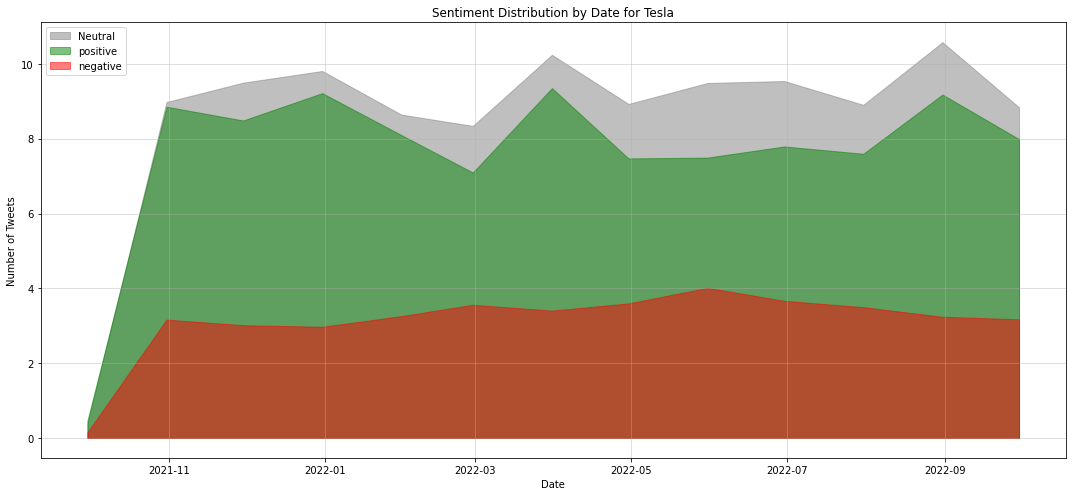

In [9]:
import matplotlib.pyplot as plt


tesla_df = merged_df[merged_df['Stock Name'] == 'TSLA']


monthly_sentiments = tesla_df.resample('M').sum()


plt.figure(figsize=(15,7))


plt.fill_between(monthly_sentiments.index, monthly_sentiments['neutral_sentiment'], color='gray', label='Neutral', alpha=0.5)
plt.fill_between(monthly_sentiments.index, monthly_sentiments['positive_sentiment'], color='green', label='positive', alpha=0.5)
plt.fill_between(monthly_sentiments.index, monthly_sentiments['negative_sentiment'], color='red', label='negative', alpha=0.5)

plt.title('Sentiment Distribution by Date for Tesla')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(loc='upper left')


plt.tight_layout()
plt.grid(True, alpha=0.5)
plt.show()

In [8]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

# Split data into train, validation, and test sets
n_months_train = 9  # First 9 months for training
n_months_val = 1    # Next 1 month for validation
window_size = 2

# Define the end dates for each split
train_end_date = merged_df.index.min() + pd.DateOffset(months=n_months_train)
val_start_date = train_end_date
val_end_date = val_start_date + pd.DateOffset(months=n_months_val)
test_start_date = val_end_date + pd.DateOffset(days=-window_size)  # Test starts right after validation

# Split the data
train_data = merged_df[:train_end_date]
val_data = merged_df[val_start_date:val_end_date]
test_data = merged_df[test_start_date:]

# Define input features
input_feature = ['Close', 'positive_sentiment']

# Data normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data[input_feature])  # Fit the scaler only on the training data

train_scaled = scaler.transform(train_data[input_feature])
val_scaled = scaler.transform(val_data[input_feature])
test_scaled = scaler.transform(test_data[input_feature])

# Convert to PyTorch tensors
train_tensors = torch.tensor(train_scaled, dtype=torch.float32)
val_tensors = torch.tensor(val_scaled, dtype=torch.float32)
test_tensors = torch.tensor(test_scaled, dtype=torch.float32)

# Create data loaders
train_loader = DataLoader(train_tensors, batch_size=64, shuffle=False)
val_loader = DataLoader(val_tensors, batch_size=64, shuffle=False)
test_loader = DataLoader(test_tensors, batch_size=64, shuffle=False)

# Function to create input-output sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + 1:i + tw + 1, 0]  # Select only 'Close' price as label
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Create input-output sequences for training and validation
train_inout_seq = create_inout_sequences(train_tensors, window_size)
val_inout_seq = create_inout_sequences(val_tensors, window_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=len(input_feature), hidden_layer_size=256, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.reshape(len(input_seq), -1))
        return predictions

# Initialize the model, loss function, and optimizer
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop with validation
epochs = 150
for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_losses = []
    for seq, label in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        single_loss = loss_function(y_pred, label.unsqueeze(dim=1))
        single_loss.backward()
        optimizer.step()
        train_losses.append(single_loss.item())

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_losses = []
        for seq, label in val_inout_seq:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)
            val_loss = loss_function(y_pred, label.unsqueeze(dim=1))
            val_losses.append(val_loss.item())

    # Print training and validation loss at intervals
    if epoch % 25 == 0:
        print(f'Epoch: {epoch:3} | Train Loss: {sum(train_losses) / len(train_losses):10.8f} | Validation Loss: {sum(val_losses) / len(val_losses):10.8f}')

# At this point, proceed to evaluate the model on the test set

Epoch:   0 | Train Loss: 0.23123709 | Validation Loss: 0.28273843
Epoch:  25 | Train Loss: 0.01814513 | Validation Loss: 0.00903842
Epoch:  50 | Train Loss: 0.01806593 | Validation Loss: 0.00908738
Epoch:  75 | Train Loss: 0.01801062 | Validation Loss: 0.00910981
Epoch: 100 | Train Loss: 0.01796618 | Validation Loss: 0.00911587
Epoch: 125 | Train Loss: 0.01792773 | Validation Loss: 0.00911958


In [18]:
train_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...                ...         ...         ...         ...         ...   
2022-06-24  237.470001  246.066666  236.086670  245.706665  245.706665   
2022-06-27  249.366669  252.070007  242.566666  244.919998  244.919998   
2022-06-28  244.483337  249.970001  232.343338  232.663330  232.663330   
2022-06-29  230.500000  231.173340  222.273331  228.490005  228.490005   
2022-06-30  224.509995  229.456665  218.863327  224.473328  224.473328   

              Volume Stock Name  negative_sentiment  neutral_sentiment  \
Date                                                                     
2021-09-30  53868000       TSLA            0.153034           0.384330   
2021-10-01  51094200       TSLA            0.140735           0.416130   
2021-10-04  91449900       TSLA            0.244534           0.466136   
2021-10-05  55297800       TSLA            0.226746           0.432151   
2021-10-06  43898400       TSLA            0.155761           0.464641   
...              ...        ...                 ...                ...   
2022-06-24  95770800       TSLA            0.182654           0.433796   
2022-06-27  89178300       TSLA            0.124200           0.470293   
2022-06-28  90391200       TSLA            0.145832           0.441800   
2022-06-29  82897200       TSLA            0.181095           0.498810   
2022-06-30  94600500       TSLA            0.217841           0.408088   

            positive_sentiment  
Date                            
2021-09-30            0.462636  
2021-10-01            0.443135  
2021-10-04            0.289330  
2021-10-05            0.341102  
2021-10-06            0.379598  
...                        ...  
2022-06-24            0.383549  
2022-06-27            0.405508  
2022-06-28            0.412368  
2022-06-29            0.320095  
2022-06-30            0.374071  

[189 rows x 10 columns]

In [20]:
val_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-30  224.509995  229.456665  218.863327  224.473328  224.473328   
2022-07-01  227.000000  230.229996  222.119995  227.263336  227.263336   
2022-07-05  223.000000  233.146667  216.166672  233.066666  233.066666   
2022-07-06  230.779999  234.563339  227.186661  231.733337  231.733337   
2022-07-07  233.919998  245.363327  232.210007  244.543335  244.543335   
2022-07-08  242.333328  254.979996  241.160004  250.763336  250.763336   
2022-07-11  252.103333  253.063339  233.626663  234.343338  234.343338   
2022-07-12  236.846664  239.773331  228.369995  233.070007  233.070007   
2022-07-13  225.500000  242.059998  225.033340  237.039993  237.039993   
2022-07-14  234.896667  238.653336  229.333328  238.313339  238.313339   
2022-07-15  240.000000  243.623337  236.889999  240.066666  240.066666   
2022-07-18  244.936661  250.516663  239.603333  240.546661  240.546661   
2022-07-19  245.000000  247.139999  236.976669  245.529999  245.529999   
2022-07-20  246.783340  250.663330  243.483337  247.500000  247.500000   
2022-07-21  255.106674  273.266663  254.866669  271.706665  271.706665   
2022-07-22  276.220001  280.786682  270.713318  272.243347  272.243347   
2022-07-25  272.216675  274.146667  267.399994  268.433319  268.433319   
2022-07-26  266.513336  267.309998  256.263336  258.859985  258.859985   
2022-07-27  263.809998  275.926666  261.790009  274.820007  274.820007   
2022-07-28  280.066681  283.299988  272.799988  280.899994  280.899994   
2022-07-29  280.700012  298.320007  279.100006  297.149994  297.149994   

               Volume Stock Name  negative_sentiment  neutral_sentiment  \
Date                                                                      
2022-06-30   94600500       TSLA            0.217841           0.408088   
2022-07-01   74460300       TSLA            0.159614           0.464277   
2022-07-05   84581100       TSLA            0.179540           0.392210   
2022-07-06   71853600       TSLA            0.165857           0.441140   
2022-07-07   81930600       TSLA            0.162517           0.453697   
2022-07-08  101854200       TSLA            0.137711           0.432933   
2022-07-11   99241200       TSLA            0.207434           0.394515   
2022-07-12   87930900       TSLA            0.199118           0.456968   
2022-07-13   97954500       TSLA            0.208945           0.486385   
2022-07-14   78557400       TSLA            0.185455           0.456397   
2022-07-15   69683100       TSLA            0.139161           0.443566   
2022-07-18   82537500       TSLA            0.161711           0.456435   
2022-07-19   80890200       TSLA            0.199680           0.481053   
2022-07-20   88864200       TSLA            0.164114           0.456176   
2022-07-21  142032300       TSLA            0.167640           0.405038   
2022-07-22  103472700       TSLA            0.168384           0.473994   
2022-07-25   64073400       TSLA            0.175560           0.444854   
2022-07-26   66820800       TSLA            0.263687           0.436466   
2022-07-27   88110000       TSLA            0.159377           0.477159   
2022-07-28   84723000       TSLA            0.167548           0.448609   
2022-07-29   95313000       TSLA            0.124469           0.402856   

            positive_sentiment  
Date                            
2022-06-30            0.374071  
2022-07-01            0.376109  
2022-07-05            0.428250  
2022-07-06            0.393003  
2022-07-07            0.383785  
2022-07-08            0.429356  
2022-07-11            0.398050  
2022-07-12            0.343913  
2022-07-13            0.304670  
2022-07-14            0.358148  
2022-07-15            0.417273  
2022-07-18            0.381854  
2022-07-19            0.319267  
2022-07-20            0.379710  
2022-07-21            0.427322  
2022-07-22            0.3576

In [21]:
test_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-07-28  280.066681  283.299988  272.799988  280.899994  280.899994   
2022-07-29  280.700012  298.320007  279.100006  297.149994  297.149994   
2022-08-01  301.276672  311.876678  295.000000  297.276672  297.276672   
2022-08-02  294.003326  307.833344  292.666656  300.586670  300.586670   
2022-08-03  305.000000  309.549988  301.149994  307.396667  307.396667   
2022-08-04  311.000000  313.606659  305.000000  308.633331  308.633331   
2022-08-05  302.670013  304.606659  285.543335  288.170013  288.170013   
2022-08-08  295.000000  305.200012  289.086670  290.423340  290.423340   
2022-08-09  290.293335  292.396667  279.353333  283.333344  283.333344   
2022-08-10  297.066681  297.510010  283.369995  294.356659  294.356659   
2022-08-11  296.513336  298.236664  285.833344  286.630005  286.630005   
2022-08-12  289.416656  300.160004  285.033325  300.029999  300.029999   
2022-08-15  301.786682  313.133331  301.230011  309.320007  309.320007   
2022-08-16  311.666656  314.666656  302.883331  306.563324  306.563324   
2022-08-17  303.396667  309.656677  300.033325  303.996674  303.996674   
2022-08-18  306.000000  306.500000  301.853333  302.869995  302.869995   
2022-08-19  299.000000  300.359985  292.500000  296.666656  296.666656   
2022-08-22  291.913330  292.399994  286.296661  289.913330  289.913330   
2022-08-23  291.453339  298.826660  287.923340  296.453339  296.453339   
2022-08-24  297.563324  303.646667  296.500000  297.096680  297.096680   
2022-08-25  302.359985  302.959991  291.600006  296.070007  296.070007   
2022-08-26  297.429993  302.000000  287.470001  288.089996  288.089996   
2022-08-29  282.829987  287.739990  280.700012  284.820007  284.820007   
2022-08-30  287.869995  288.480011  272.649994  277.700012  277.700012   
2022-08-31  280.619995  281.250000  271.809998  275.609985  275.609985   
2022-09-01  272.579987  277.579987  266.149994  277.160004  277.160004   
2022-09-02  281.070007  282.350006  269.079987  270.209991  270.209991   
2022-09-06  272.679993  275.989990  265.739990  274.420013  274.420013   
2022-09-07  273.100006  283.839996  272.269989  283.700012  283.700012   
2022-09-08  281.299988  289.500000  279.760010  289.260010  289.260010   
2022-09-09  291.670013  299.850006  291.250000  299.679993  299.679993   
2022-09-12  300.720001  305.489990  300.399994  304.420013  304.420013   
2022-09-13  292.899994  297.399994  290.399994  292.130005  292.130005   
2022-09-14  292.239990  306.000000  291.640015  302.609985  302.609985   
2022-09-15  301.829987  309.119995  300.720001  303.750000  303.750000   
2022-09-16  299.609985  303.709991  295.600006  303.350006  303.350006   
2022-09-19  300.089996  309.839996  297.799988  309.070007  309.070007   
2022-09-20  306.910004  313.329987  305.579987  308.730011  308.730011   
2022-09-21  308.290009  313.799988  300.630005  300.799988  300.799988   
2022-09-22  299.859985  301.290009  285.820007  288.589996  288.589996   
2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

               Volume Stock Name  negative_sentiment  neutral_sentiment  \
Date                                                                      
2022-07-28   84723000       TSLA            0.167548           0.448609   
2022-07-29   95313000       TSLA            0.124469           0.402856   
2022-08-01  117042900       TSLA            0.117723           0.478292   
2022-08-02   95577600       TSLA            0.115602           0.505884   
2022-08-03   80091000       TSLA            0.103222           0.422028   
2022-08-04   7

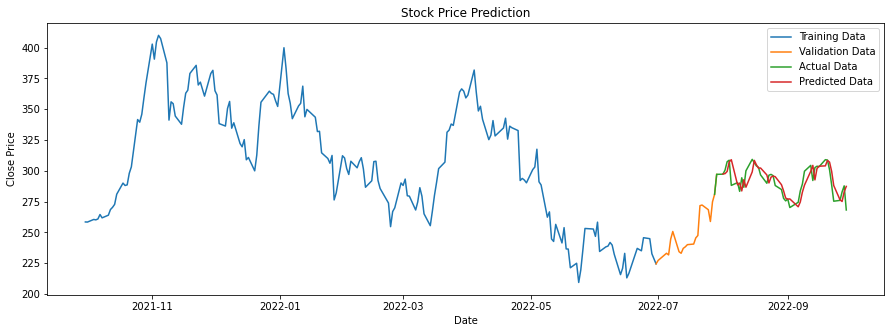

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been trained and the test data is prepared

model.eval()  # Set the model to evaluation mode
test_inout_seq = create_inout_sequences(test_tensors, window_size)
test_predictions = []

with torch.no_grad():
    for seq, label in test_inout_seq:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        # Predict and store the last predicted value for each sequence
        test_predictions.append(model(seq)[-1].detach().numpy())

# Convert predictions to a numpy array and flatten it
test_predictions = np.array(test_predictions).flatten()

# Pad predictions with ones for other features to inverse transform correctly
test_pred_full = np.ones((len(test_predictions), len(input_feature)))
test_pred_full[:, 0] = test_predictions  # Insert predictions into the first column ('Close' price)

# Inverse transform the validation data 'Close' prices
val_data_rescaled = scaler.inverse_transform(val_scaled)[:, 0]  # Select only the 'Close' price

# Inverse transform the predictions to get them back on the original scale
test_pred_rescaled = scaler.inverse_transform(test_pred_full)[:, 0]  # Select only the 'Close' price

# Inverse transform the actual test data 'Close' prices for comparison
test_data_rescaled = scaler.inverse_transform(test_scaled)[:, 0]  # Select only the 'Close' price

# Align predictions with the correct dates
offset_date = test_data.index.min() + pd.DateOffset(days=window_size)
demo_index = test_data.index[window_size:]  # Align indices with the predictions
demo = pd.DataFrame(index=demo_index, data={'Predicted': test_pred_rescaled})

# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(train_data['Close'], label='Training Data')
plt.plot(val_data.index, val_data_rescaled, label='Validation Data')  # Plot actual 'Close' prices for the validation set
plt.plot(test_data.index, test_data_rescaled, label='Actual Data')  # Plot actual 'Close' prices for the test set
plt.plot(demo.index, demo['Predicted'], label='Predicted Data')  # Plot predicted values
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [24]:
demo

Predicted
Date                  
2022-08-01  297.431680
2022-08-02  297.719770
2022-08-03  299.470264
2022-08-04  307.172541
2022-08-05  309.051974
2022-08-08  288.596293
2022-08-09  290.088101
2022-08-10  283.673229
2022-08-11  292.819984
2022-08-12  286.694830
2022-08-15  299.119768
2022-08-16  308.496421
2022-08-17  304.891598
2022-08-18  302.157513
2022-08-19  302.280117
2022-08-22  296.672739
2022-08-23  290.176501
2022-08-24  294.872607
2022-08-25  295.731089
2022-08-26  295.255228
2022-08-29  288.724770
2022-08-30  283.759929
2022-08-31  277.904515
2022-09-01  277.002219
2022-09-02  277.187389
2022-09-06  270.802885
2022-09-07  274.709322
2022-09-08  282.652419
2022-09-09  288.369740
2022-09-12  299.628732
2022-09-13  304.410419
2022-09-14  292.637610
2022-09-15  301.869844
2022-09-16  303.750094
2022-09-19  304.020961
2022-09-20  308.464692
2022-09-21  307.036226
2022-09-22  299.590736
2022-09-23  288.050938
2022-09-26  276.464440
2022-09-27  275.117771
2022-09-28  283.062072
2022-09-29  287.345376

Mean Absolute Error (MAE): 6.0604
Mean Squared Error (MSE): 56.6026
Root Mean Squared Error (RMSE): 7.5235
R² Score: 0.5371
Mean Absolute Percentage Error (MAPE): 0.0207


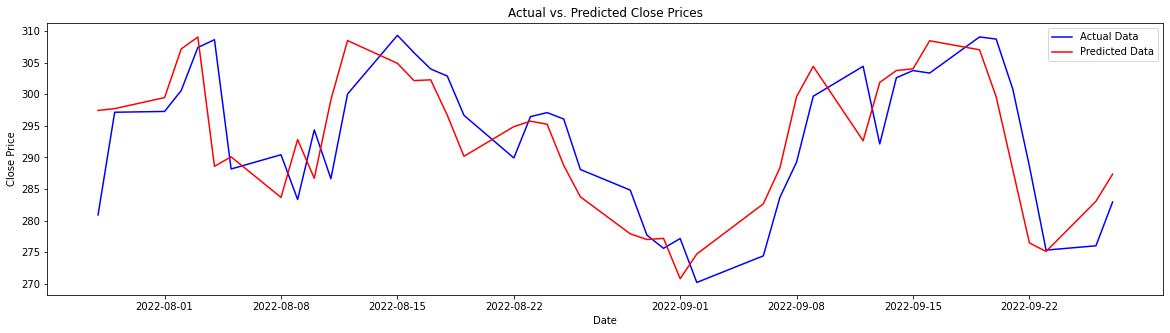

RMSE as a percentage of the mean close price: 2.57%


In [30]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Ensure that test_pred_rescaled matches the length of test_data_rescaled
if len(test_pred_rescaled) != len(test_data_rescaled):
    # Align the lengths (assuming the discrepancy is due to boundary issues)
    min_length = min(len(test_pred_rescaled), len(test_data_rescaled))
    test_data_rescaled = test_data_rescaled[:min_length]
    test_pred_rescaled = test_pred_rescaled[:min_length]
    
# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data_rescaled, test_pred_rescaled)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_data_rescaled, test_pred_rescaled)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

r2 = r2_score(test_data_rescaled, test_pred_rescaled)
mape = mean_absolute_percentage_error(test_data_rescaled, test_pred_rescaled)

print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')


# Plot Actual vs. Predicted
plt.figure(figsize=(20,5))
plt.plot(test_data.index[:len(test_data_rescaled)], test_data_rescaled, label='Actual Data', color='blue')
plt.plot(test_data.index[:len(test_pred_rescaled)], test_pred_rescaled, label='Predicted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()
plt.show()

mean_close_price = np.mean(test_data_rescaled)
rmse_percentage = (rmse / mean_close_price) * 100
print(f'RMSE as a percentage of the mean close price: {rmse_percentage:.2f}%')

In [29]:
mean_close_price = np.mean(test_data_rescaled)
rmse_percentage = (rmse / mean_close_price) * 100
print(f'RMSE as a percentage of the mean close price: {rmse_percentage:.2f}%')


RMSE as a percentage of the mean close price: 2.57%
